<a href="https://colab.research.google.com/github/caiogoia123/projeto_final_marvel/blob/insights_bia/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#bibliotecas
import requests
import hashlib
import time
import datetime
from google.colab import userdata
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np

In [ ]:
#chaves
public_key=userdata.get('public_key_marvel')
private_key=userdata.get('private_key_marvel')

In [ ]:
#variáveis globais
DB_NAME = 'banco_marvel.db'
MAX_RETRIES = 3  # Tentativas por requisição
DELAY = 1  # Atraso entre requisições em segundos
DEFAULT_LIMIT = 100
BASE_TIMEOUT = 10

# Criação banco de dados

In [ ]:
# with sqlite3.connect(DB_NAME) as conn:
#     cursor = conn.cursor()

#     # Executar consulta para dropar a tabela series
#     cursor.execute('''
#         DROP TABLE IF EXISTS series;
#     ''')

In [ ]:
 # Função para criar o banco
def create_database():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    # Tabela Personagens
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela Comics
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS comics (
        id INTEGER PRIMARY KEY,
        digital_id INTENGER,
        title TEXT NOT NULL,
        issue_number INTEGER,
        description TEXT,
        variant_description TEXT,
        modified TEXT,
        format TEXT,
        page_count INTEGER,
        series_URI TEXT,
        series_name TEXT,
        price REAL,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS series (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        start_year INTEGER,
        end_year INTEGER,
        rating TEXT,
        modified TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        events_available INTEGER,
        events_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT
    )''')

    # Tabela Events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        modified TEXT,
        start TEXT,
        end TEXT,
        comics_available INTEGER,
        comics_collectionURI TEXT,
        characters_available INTEGER,
        characters_collectionURI TEXT,
        stories_available INTEGER,
        stories_collectionURI TEXT,
        creators_available INTEGER,
        creators_collectionURI TEXT,
        series_available INTEGER,
        series_collectionURI TEXT
    )''')

    # Tabela de relacionamento characters e events
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_events (
        id_character INTEGER,
        id_event INTEGER,
        PRIMARY KEY(id_character, id_event),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_event) REFERENCES events(id)
    )''')

    # Tabela de relacionamento characters e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS characters_series (
        id_character INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_character, id_serie),
        FOREIGN KEY(id_character) REFERENCES characters(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    # Tabela de relacionamento events e series
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS events_series (
        id_event INTEGER,
        id_serie INTEGER,
        PRIMARY KEY(id_event, id_serie),
        FOREIGN KEY(id_event) REFERENCES events(id),
        FOREIGN KEY(id_serie) REFERENCES series(id)
    )''')

    conn.commit()
    conn.close()

In [ ]:
#tabelas do banco e quantidades de linhas para cada uma
with sqlite3.connect(DB_NAME) as conn:
    cursor = conn.cursor()

    # Buscar todas as tabelas do banco
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabelas = [t[0] for t in cursor.fetchall()]

    print("Tabelas e seus tamanhos:")
    for nome in tabelas:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")

In [ ]:
# create_database()

# Extração de dados

In [ ]:
#parametros para requisições
def get_params():
    ts = str(time.time())
    hash_input = ts + private_key + public_key
    md5_hash = hashlib.md5(hash_input.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': md5_hash
    }

In [ ]:
#fazer requisição
def fetch_data(endpoint, offset, limit=DEFAULT_LIMIT, timeout = BASE_TIMEOUT):
    params = get_params()
    params.update({'limit': limit, 'offset': offset})

    response = requests.get(
        f'https://gateway.marvel.com/v1/public/{endpoint}',
        params=params,
        timeout=timeout
    )

    response.raise_for_status()
    return response.json()

In [ ]:
#pegar todos os dados de uma endpoint e inserir no banco
def get_all_data(endpoint, insert_fn, limit=DEFAULT_LIMIT):
    offset = 0
    total = None
    inserted = 0

    with sqlite3.connect(DB_NAME) as conn:
        cursor = conn.cursor()

        # Continua enquanto não souber o total ou ainda houver registros a buscar
        while total is None or offset < total:
            for attempt in range(1, MAX_RETRIES + 1):
                try:
                    data = fetch_data(endpoint, offset, limit)
                    if total is None:
                      total = data['data']['total']
                    results = data['data']['results']

                    if not results:
                        print(f"Sem mais dados para o endpoint {endpoint}.")
                        return

                    for item in results:
                        insert_fn(cursor, item)

                    conn.commit()
                    inserted += len(results)

                    print(f"Progresso {endpoint}: {inserted}/{total} ({inserted/total:.1%})")

                    offset += limit
                    time.sleep(DELAY)
                    break  # Sucesso, não tenta novamente

                except requests.exceptions.RequestException as e:
                    print(f"Erro na requisição {endpoint} (tentativa {attempt}): {e}")
                    time.sleep(2 ** attempt)  # Backoff exponencial
            else:
                print(f"Falha após múltiplas tentativas em {endpoint}. Abortando...")
                return  # Abortando sem sucesso total

        print(f"\nTodos os dados de {endpoint} foram armazenados!")

In [ ]:
#inserção de dados na tabela de personagens
def insert_character(cursor, character_data):
    cursor.execute('''
        INSERT OR REPLACE INTO characters
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        character_data['id'],
        character_data['name'],
        character_data.get('description', ''),
        character_data['modified'],
        character_data['comics']['available'],
        character_data['comics']['collectionURI'],
        character_data['events']['available'],
        character_data['events']['collectionURI'],
        character_data['stories']['available'],
        character_data['stories']['collectionURI'],
        character_data['series']['available'],
        character_data['series']['collectionURI'],
    ))

In [ ]:
#inserção de dados na tabela de eventos
def insert_event(cursor, event_data):
  cursor.execute('''
      INSERT OR REPLACE INTO events
      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
      ''', (
      event_data['id'],
      event_data['title'],
      event_data.get('description', ''),
      event_data['modified'],
      event_data['start'],
      event_data['end'],
      event_data['comics']['available'],
      event_data['comics']['collectionURI'],
      event_data['characters']['available'],
      event_data['characters']['collectionURI'],
      event_data['stories']['available'],
      event_data['stories']['collectionURI'],
      event_data['creators']['available'],
      event_data['creators']['collectionURI'],
      event_data['series']['available'],
      event_data['series']['collectionURI'],
  ))

In [ ]:
#inserção de dados na tabela de quadrinhos
def insert_comic(cursor, comic_data):
    cursor.execute('''INSERT OR REPLACE INTO comics
                      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                  (
                      comic_data['id'],
                      comic_data['digitalId'],
                      comic_data['title'],
                      comic_data['issueNumber'],
                      comic_data.get('description', ''),
                      comic_data['variantDescription'],
                      comic_data['modified'],
                      comic_data['format'],
                      comic_data['pageCount'],
                      comic_data['series']['resourceURI'],
                      comic_data['series']['name'],
                      comic_data['prices'][-1]['price'],
                      comic_data['stories']['available'],
                      comic_data['stories']['collectionURI'],
                      comic_data['events']['available'],
                      comic_data['events']['collectionURI'],
                      comic_data['characters']['available'],
                      comic_data['characters']['collectionURI'],
                      comic_data['creators']['available'],
                      comic_data['creators']['collectionURI']
                  ))

In [ ]:
#inserção de dados na tabela de série de quadrinhos
def insert_serie(cursor, serie_data):
    cursor.execute('''INSERT OR REPLACE INTO series
                      VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                  (
                      serie_data['id'],
                      serie_data['title'],
                      serie_data.get('description', ''),
                      serie_data['startYear'],
                      serie_data['endYear'],
                      serie_data['rating'],
                      serie_data['modified'],
                      serie_data['comics']['available'],
                      serie_data['comics']['collectionURI'],
                      serie_data['stories']['available'],
                      serie_data['stories']['collectionURI'],
                      serie_data['events']['available'],
                      serie_data['events']['collectionURI'],
                      serie_data['characters']['available'],
                      serie_data['characters']['collectionURI'],
                      serie_data['creators']['available'],
                      serie_data['creators']['collectionURI']
                  ))

In [ ]:
#characters
#get_all_data('characters', insert_character)

#comics
#get_all_data('comics', insert_comic)

#events
#get_all_data('events', insert_event, 1)

#series
#get_all_data('series', insert_serie)

#Tabelas de Relacionamentos

In [ ]:
#bibliotecas usadas para tabelas de relacionamento
from requests.exceptions import ReadTimeout, RequestException
from urllib.parse import urlparse

In [ ]:
#extrair endpoint relativo de uma collection_uri completa.
def extract_endpoint(collection_uri):
    parsed = urlparse(collection_uri)
    return parsed.path.lstrip('/').replace('v1/public/', '', 1)

In [ ]:
#extração de dados e inserção em tabelas de relacionamento
def insert_relationship_data(source_table, source_field, available_field, target_table, limit_=DEFAULT_LIMIT):
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()
    error_entities = []

    print(f"[INÍCIO] Processando {source_table}.{source_field}")

    cursor.execute(
        f'SELECT id, {source_field} FROM {source_table} WHERE {available_field} > 0'
    )
    resultados = cursor.fetchall()
    total = len(resultados)
    print(f"[BANCO] Total de registros encontrados: {total}")

    for idx, (entity_id, collection_uri) in enumerate(resultados, start=1):
        print(f"\n[{source_table.upper()} {idx}/{total}] Processando ID: {entity_id}")

        try:
            all_results = []
            offset = 0
            total_items = None

            endpoint = extract_endpoint(collection_uri)

            while True:
                for attempt in range(MAX_RETRIES):
                    current_timeout = BASE_TIMEOUT * (attempt + 1)
                    print(f"  [TENTATIVA {attempt + 1}/{MAX_RETRIES}] timeout={current_timeout}s")

                    try:
                        data = fetch_data(
                            endpoint,
                            offset=offset,
                            limit=limit_,
                            timeout=current_timeout
                        )

                        if offset == 0:
                            total_items = data['data']['total']
                            print(f"  [INFO] Total de itens: {total_items}")

                        results = data['data']['results']
                        all_results.extend(results)
                        break  # sucesso

                    except ReadTimeout:
                        print("    [ERRO] ReadTimeout, fazendo retry")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(2 ** attempt)

                    except RequestException as e:
                        print(f"    [ERRO] RequestException: {e}")
                        if attempt == MAX_RETRIES - 1:
                            raise
                        time.sleep(1)

                # Condição de parada da paginação
                if total_items is not None and offset + limit_ >= total_items:
                    break

                offset += limit_
                time.sleep(0.5)

            if all_results:
                print(f"  [BANCO] Inserindo {len(all_results)} registros para {entity_id}")
                dados = [(entity_id, item['id']) for item in all_results]
                cursor.executemany(
                    f'INSERT OR IGNORE INTO {target_table} VALUES (?, ?)',
                    dados
                )
                conn.commit()
            else:
                print("  [INFO] Nenhum item para inserir")

        except Exception as e:
            print(f"  [ERRO FATAL] Registro {entity_id} falhou: {e}")
            error_entities.append(entity_id)

        if idx % 10 == 0:
            print(f"\n[ERROS ATÉ {idx}]: {error_entities}\n")

    conn.close()
    print("[BANCO] Conexão fechada")

    if error_entities:
        print(f"[RESUMO DE ERROS] Total de registros com erro: {len(error_entities)}")
        print(error_entities)
    else:
        print("[RESUMO DE ERROS] Nenhum erro encontrado.")


In [ ]:
#tabela characters-events
#insert_relationship_data(source_table='characters', source_field='events_collectionURI', available_field='events_available', target_table='characters_events', limit_ = 50)

#tabela characters-series
#insert_relationship_data(source_table='characters', source_field='series_collectionURI', available_field='series_available', target_table='characters_series')

#tabela events-series
#insert_relationship_data(source_table='events', source_field='series_collectionURI', available_field='series_available', target_table='events_series')

#Modificando o Banco

modificando tabela comics para relação com series a partir do id

In [ ]:
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute(''' ALTER TABLE comics ADD COLUMN id_series INTEGER REFERENCES series(id)
              ''')
conn.commit()
conn.close()

In [ ]:
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute(''' SELECT c.id, s.id
                  FROM comics c
                  JOIN series s ON c.series_name = s.title
              ''')

for i, j in cursor.fetchall():
     cursor.execute(''' UPDATE comics SET id_series = ? WHERE id = ?
               ''', (j, i))

conn.commit()
conn.close()

In [ ]:
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute(''' ALTER TABLE comics DROP COLUMN series_name
              ''')
conn.commit()
conn.close()

In [ ]:
conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute(''' ALTER TABLE comics DROP COLUMN series_URI
              ''')
conn.commit()
conn.close()

retirando valores maiúculos do format na comics

In [ ]:
# conn = sqlite3.connect(DB_NAME)
# cursor = conn.cursor()

# cursor.execute(''' SELECT id, format
#                    FROM comics
#               ''')

# for i, j in cursor.fetchall():
#      if (j == 'MAGAZINE'):
#       cursor.execute(''' UPDATE comics SET format = "Magazine" WHERE id = ?
#                 ''', (i,))

#      if (j == 'DIGITAL COMIC'):
#       cursor.execute(''' UPDATE comics SET format = "Digital Comic" WHERE id = ?
#                 ''', (i,))

#      if (j == 'NEWSPAPER'):
#       cursor.execute(''' UPDATE comics SET format = "Newspaper" WHERE id = ?
#                 ''', (i,))

# conn.commit()
# conn.close()

retirando tabelas de collectionURI e available

# Consultando o banco de dados

quantidade de linhas para cada tabela

In [ ]:
#tabelas do banco e quantidades de linhas para cada uma
with sqlite3.connect(DB_NAME) as conn:
    cursor = conn.cursor()

    # Buscar todas as tabelas do banco
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabelas = [t[0] for t in cursor.fetchall()]

    print("Tabelas e seus tamanhos:")
    for nome in tabelas:
        cursor.execute(f"SELECT COUNT(*) FROM {nome}")
        total = cursor.fetchone()[0]
        print(f"{nome}: {total} linhas")

descrição estatistica de valores númericos das tabelas

In [ ]:
def describe_table():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT *
                        FROM comics
                        ''', conn)
    conn.close()

    return df.describe()

describe_table()

selects diversos

In [ ]:
#series com média de preço maior e o formato delas
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, c.format, AVG(price) AS media_preco
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE format != '' AND price != 0.00
                        GROUP BY s.title, c.format
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#classificação indicativa das series
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT rating, COUNT(*) contagem
                        FROM series
                        GROUP BY rating
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem page_count comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT page_count, COUNT(*) contagem
                        FROM comics
                        GROUP BY page_count
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#contagem issue number comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT issue_number, COUNT(*) contagem
                        FROM comics
                        GROUP BY issue_number
                        ORDER BY contagem DESC
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 15''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT name, events_available FROM characters ORDER BY events_available DESC''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#média preço series em andamento
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title AS nome_series, s.start_year, end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00 AND end_year > 2025
                        GROUP BY s.title, s.start_year, s.end_year
                        ORDER BY media_preco DESC  ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#events e series
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT
                        e.id          AS event_id,
                        e.title       AS event_title,
                        s.id          AS series_id,
                        s.title       AS series_title,
                        s.start_year  AS series_start_year,
                        s.end_year    AS series_end_year
                      FROM events AS e
                      JOIN events_series AS es
                        ON e.id = es.id_event
                      JOIN series AS s
                        ON es.id_serie = s.id
                      ORDER BY e.title, s.start_year;''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com mais eventos
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.name, COUNT(*) AS num_events
                        FROM characters_events ce JOIN  characters c
                        ON c.id = ce.id_character
                        GROUP BY c.name
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#eventos mais longos tem mais séries

#Insights?

##séries - quantas séries foram iniciadas em cada ano? (1990-2025)

In [ ]:
conn = sqlite3.connect(DB_NAME)
df = pd.read_sql('''SELECT start_year,
                            COUNT(DISTINCT id) AS num_series_started
                    FROM series
                    WHERE
                        start_year IS NOT NULL
                        AND start_year >= 1990
                        AND start_year <= 2025
                    GROUP BY start_year
                    ORDER BY start_year ASC;''', conn)
conn.close()
df

##séries - número de comics, edições e variantes

In [ ]:
#séries com mais quadrinhos (com nº de variantes e nº de edições)
conn = sqlite3.connect(DB_NAME)
df = pd.read_sql('''SELECT s.title AS série_quadrinhos,
                        COUNT(c.id) AS total_quadrinhos,
                        SUM(CASE WHEN c.variant_description IS NOT NULL AND c.variant_description != '' THEN 1 ELSE 0 END) AS num_variantes,
                        SUM(CASE WHEN (c.variant_description IS NULL OR c.variant_description = '')
                                    AND c.issue_number IS NOT NULL AND c.issue_number > 0 THEN 1 ELSE 0 END) AS num_edições_regulares
                    FROM series s
                    JOIN comics c ON s.id = c.id_series
                    GROUP BY s.title
                    ORDER BY total_quadrinhos DESC
                    LIMIT 10;''', conn)
conn.close()
df

In [ ]:
#séries em andamento com mais quadrinhos (com nº de variantes e nº de edições)
conn = sqlite3.connect(DB_NAME)
df = pd.read_sql('''SELECT s.title AS série_quadrinhos,
                          COUNT(c.id) AS total_quadrinhos,
                          SUM(CASE WHEN c.variant_description IS NOT NULL AND c.variant_description != '' THEN 1 ELSE 0 END) AS num_variantes,
                          SUM(CASE WHEN (c.variant_description IS NULL OR c.variant_description = '')
                                      AND c.issue_number IS NOT NULL AND c.issue_number > 0 THEN 1 ELSE 0 END) AS num_edições_regulares
                      FROM series s
                      JOIN comics c ON s.id = c.id_series
                      WHERE s.end_year > 2025
                      GROUP BY s.title
                      ORDER BY total_quadrinhos DESC
                      LIMIT 10;''', conn)
conn.close()
df

In [ ]:
#series com mais comics
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title, COUNT(c.id) AS num_comics
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        GROUP BY s.title
                        ORDER BY COUNT(*) DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais issues (sem variantes)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_issues, ROUND(AVG(c.price),2) media_preco_issues
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description == '' AND issue_number != '' AND issue_number > 0 AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_issues DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#series com mais variantes
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT s.title serie, COUNT(c.id) num_variantes, ROUND(AVG(c.price),2) media_preco_variantes
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.variant_description != '' AND c.price != 0.00
                        GROUP BY s.title
                        ORDER BY num_variantes DESC
                        LIMIT 15
                         ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

##personagens - números de series que ele está presente (com média de preço)

In [ ]:
#personagens com maior num series geral
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com maior num series em andamento
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        ORDER BY num_series DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens maior preço médio por serie (com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

In [ ]:
#personagens com maior preço médio por serie em andamento(com mais de 5 series)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH series_avg as (
                        SELECT s.id, s.end_year, AVG(c.price) AS media_preco
                        FROM comics c JOIN  series s
                        ON c.id_series = s.id
                        WHERE c.price != 0.00
                        GROUP BY s.id, s.end_year
                        )

                        SELECT c.name AS nome_personagem, COUNT(s.id) AS num_series, ROUND(AVG(s.media_preco),2) AS media_preco
                        FROM characters c JOIN  characters_series cs
                        ON c.id = cs.id_character
                        JOIN series_avg s
                        ON cs.id_serie = s.id
                        WHERE s.end_year > 2025
                        GROUP BY c.name
                        HAVING num_series > 5
                        ORDER BY media_preco DESC
                        LIMIT 10''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

##média de preço e contagem por formato de comic

In [ ]:
#formatos de comics (quantidade e média de preço)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT format, COUNT(id) AS num_comics, ROUND(AVG(price),2) AS media_preço
                        FROM comics
                        WHERE price != 0 AND format != ''
                        GROUP BY format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()

In [ ]:
#formatos de comics das séries iniciadas a partir de 2015 (quantidade e média de preço)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.format, COUNT(c.id) AS num_comics, ROUND(AVG(c.price),2) AS media_preço
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.price != 0 AND c.format != '' AND s.start_year > 2015
                        GROUP BY c.format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df
show_table_sample()

In [ ]:
#usando modified
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT format, COUNT(id), AVG(price) avg_price
                        FROM comics
                        WHERE price != 0 AND format != '' AND CAST(substr(modified,1,4) AS INTEGER) >= 2020
                        GROUP BY format
                        ORDER BY avg_price DESC
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

##eventos - séries e personagens

In [ ]:
#eventos com mais series (com contagem de personagens)
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''WITH events_count_series as (
                        SELECT e.id, COUNT(es.id_serie) num_series
                        FROM events e JOIN  events_series es
                        ON e.id = es.id_event
                        GROUP BY e.id
                        ),

                        events_count_characters as (
                            SELECT e.id, COUNT(ce.id_character) num_characters
                        FROM events e JOIN characters_events ce
                        ON e.id = ce.id_event
                        GROUP BY e.id
                        )

                        SELECT e.title as evento, ecs.num_series, ecc.num_characters
                        FROM events e
                        JOIN events_count_series ecs
                        ON e.id = ecs.id
                        JOIN events_count_characters ecc
                        ON e.id = ecc.id
                        ORDER BY ecs.num_series DESC
                        LIMIT 20''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

show_table_sample()

#Gráficos dos Insights

In [12]:
#bibliotecas usadas nos gráficos
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

##1. gráfico: séries iniciadas em cada ano (1990-2025)

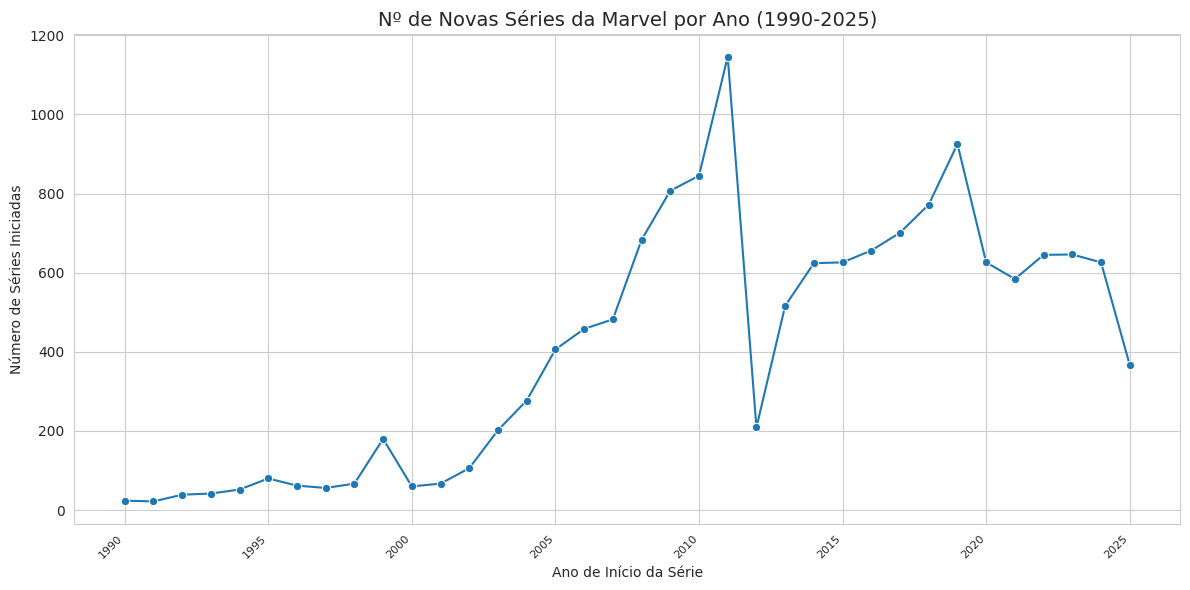

In [13]:
def fetch_series_started_by_year_filtered():
    """Busca o número de séries iniciadas por ano, dentro de um intervalo."""
    with sqlite3.connect(DB_NAME) as conn:
        query = f"""
            SELECT
                start_year,
                COUNT(DISTINCT id) AS num_series_started
            FROM
                series
            WHERE
                start_year IS NOT NULL
                AND start_year >= 1990
                AND start_year <= 2025
            GROUP BY
                start_year
            ORDER BY
                start_year ASC;
        """
        df = pd.read_sql_query(query, conn)
    return df

df_series_by_year_filtered = fetch_series_started_by_year_filtered()

# Plotar o gráfico apenas se houver dados
if not df_series_by_year_filtered.empty:
    plt.figure(figsize=(12, 6)) # Tamanho razoável para o gráfico
    sns.set_style("whitegrid") # Estilo limpo

    sns.lineplot(
        data=df_series_by_year_filtered,
        x='start_year',
        y='num_series_started',
        marker='o',       # Adiciona marcadores para destacar os anos
        linewidth=1.5     # Espessura da linha
    )

    plt.title(f'Nº de Novas Séries da Marvel por Ano (1990-2025)', fontsize=14)
    plt.xlabel('Ano de Início da Série', fontsize=10)
    plt.ylabel('Número de Séries Iniciadas', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8) # Rotação para melhor leitura dos anos
    plt.yticks(fontsize=10)


    plt.tight_layout() # Ajusta o layout para não cortar os rótulos
    plt.show()

O Marvel NOW! foi um grande relançamento da linha editorial da Marvel Comics que começou no final de 2012, após a conclusão do evento "Avengers vs. X-Men". A maior parte das novas séries e novas equipes criativas associadas a essa iniciativa tiveram seus lançamentos e consolidação ao longo de 2013.

##2. gráfico duração das séries

--- Insight 1: Distribuição da Duração das Séries de Quadrinhos Concluídas ---


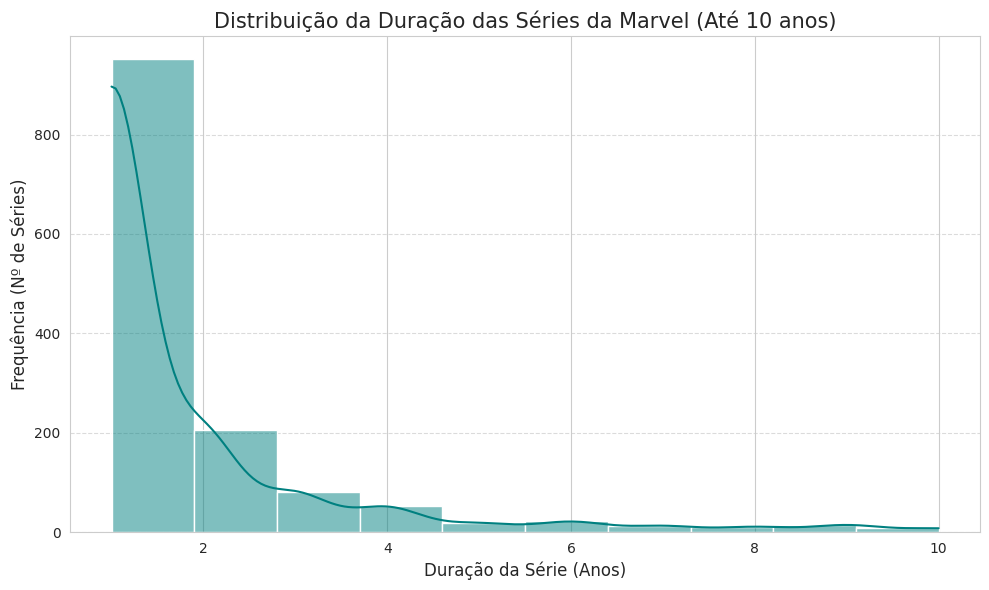

In [14]:
def fetch_series_durations():
    """
    Busca a duração das séries de quadrinhos concluídas.
    """
    with sqlite3.connect(DB_NAME) as conn:
        # Consideramos séries concluídas aquelas com end_year < 2025 (ano atual da simulação)
        # e onde start_year e end_year são válidos e end_year > start_year.
        query = """
            SELECT
                title,
                (end_year - start_year) AS duracao_em_anos
            FROM
                series
            WHERE
                start_year IS NOT NULL
                AND end_year IS NOT NULL
                AND end_year > start_year
                AND end_year < 2025
                AND duracao_em_anos < 11; -- Filtro para séries já concluídas
        """
        df = pd.read_sql_query(query, conn)
    return df

df =fetch_series_durations()

# --- Análise: Distribuição da Duração das Séries Concluídas ---
print("--- Insight 1: Distribuição da Duração das Séries de Quadrinhos Concluídas ---")
df_series_durations = fetch_series_durations()


# 2. Gráfico: Histograma da Duração das Séries
plt.figure(figsize=(10, 6))
# Filtrar durações muito longas para melhor visualização do histograma principal, se necessário
# Exemplo: Focar em séries com até 30 anos de duração para o plot principal
max_duration_to_plot = 10
data_to_plot = df_series_durations[df_series_durations['duracao_em_anos'] <= max_duration_to_plot]['duracao_em_anos']

if not data_to_plot.empty:
    sns.histplot(data_to_plot, kde=True, bins=min(len(data_to_plot.unique()), 30), color='teal')
    plt.title(f'Distribuição da Duração das Séries da Marvel (Até {max_duration_to_plot} anos)', fontsize=15)
    plt.xlabel('Duração da Série (Anos)', fontsize=12)
    plt.ylabel('Frequência (Nº de Séries)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Informar sobre séries com duração maior que o limite do plot, se houver
    longer_series_count = len(df_series_durations[df_series_durations['duracao_em_anos'] > max_duration_to_plot])
    if longer_series_count > 0:
        print(f"\nNota: {longer_series_count} séries tiveram duração maior que {max_duration_to_plot} anos e não estão detalhadas no histograma.")
else:
    print(f"\nNão há séries com duração de até {max_duration_to_plot} anos para plotar.")

##3. gráfico: séries com mais quadrinhos (com nº de variantes e nº de edições regulares)

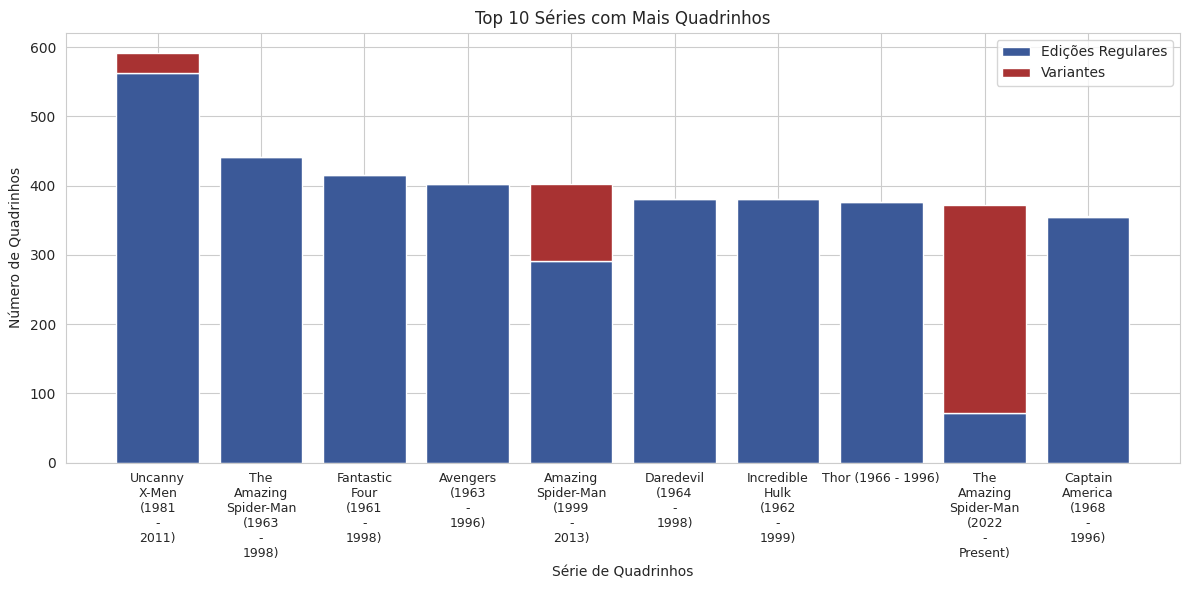

In [15]:
# Conexão e consulta
with sqlite3.connect(DB_NAME) as conn:
    df_2 = pd.read_sql("""
        SELECT s.title AS série_quadrinhos,
               COUNT(c.id) AS total_quadrinhos,
               SUM(CASE WHEN c.variant_description IS NOT NULL AND c.variant_description != '' THEN 1 ELSE 0 END) AS num_variantes,
               SUM(CASE WHEN (c.variant_description IS NULL OR c.variant_description = '')
                          AND c.issue_number IS NOT NULL AND c.issue_number > 0 THEN 1 ELSE 0 END) AS num_edições_regulares
        FROM series s
        JOIN comics c ON s.id = c.id_series
        GROUP BY s.title
        ORDER BY total_quadrinhos DESC
        LIMIT 10;
    """, conn)

# Quebra de linha apenas para nomes muito longos
df_2['série_quadrinhos'] = df_2['série_quadrinhos'].apply(lambda x: '\n'.join(x.split(' ')) if len(x) > 20 else x)

plt.figure(figsize=(12, 6))

# Cores
cor_regulares = '#3b5998'
cor_variantes = '#a83232'

plt.bar(
    df_2['série_quadrinhos'],
    df_2['num_edições_regulares'],
    label='Edições Regulares',
    color=cor_regulares
)

plt.bar(
    df_2['série_quadrinhos'],
    df_2['num_variantes'],
    bottom=df_2['num_edições_regulares'],
    label='Variantes',
    color=cor_variantes
)

plt.xlabel('Série de Quadrinhos')
plt.ylabel('Número de Quadrinhos')
plt.title('Top 10 Séries com Mais Quadrinhos')


plt.xticks(rotation=0, ha='center', fontsize=9)  # rotação zero e central

plt.subplots_adjust(bottom=0.25)
plt.rcParams['font.family'] = 'DejaVu Sans'

plt.legend()
plt.tight_layout()

plt.show()


3.1 gráfico: séries em andamento com mais quadrinhos (com nº de variantes e nº de edições regulares)

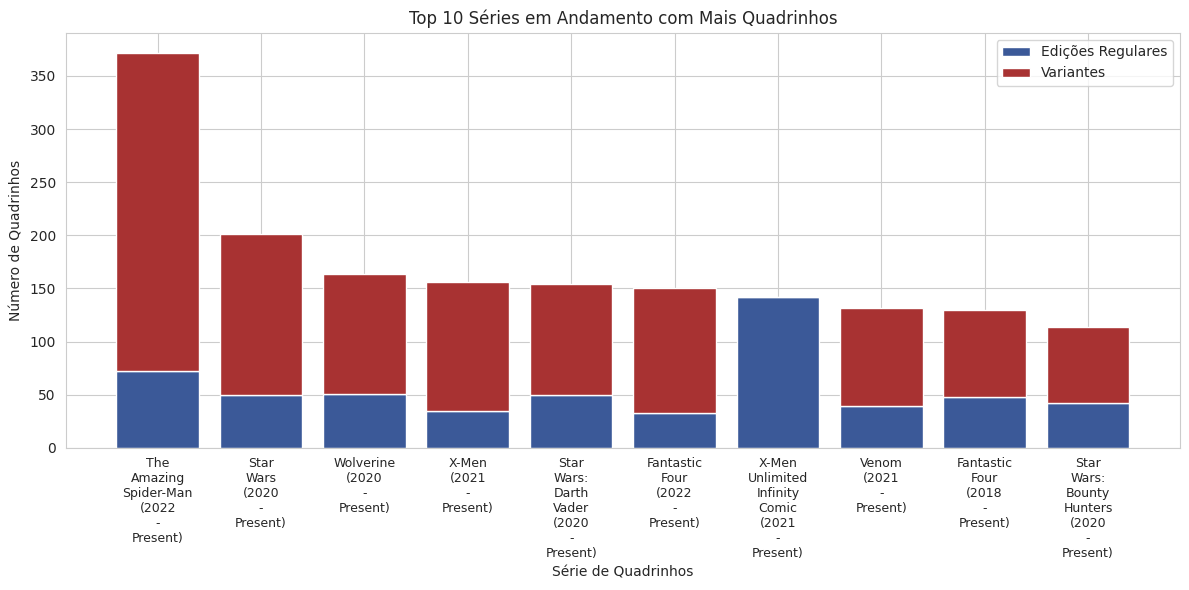

In [16]:
# Conexão e consulta
with sqlite3.connect(DB_NAME) as conn:
    df_2 = pd.read_sql("""
        SELECT s.title AS série_quadrinhos,
               COUNT(c.id) AS total_quadrinhos,
               SUM(CASE WHEN c.variant_description IS NOT NULL AND c.variant_description != '' THEN 1 ELSE 0 END) AS num_variantes,
               SUM(CASE WHEN (c.variant_description IS NULL OR c.variant_description = '')
                          AND c.issue_number IS NOT NULL AND c.issue_number > 0 THEN 1 ELSE 0 END) AS num_edições_regulares
        FROM series s
        JOIN comics c ON s.id = c.id_series
        WHERE s.end_year > 2025
        GROUP BY s.title
        ORDER BY total_quadrinhos DESC
        LIMIT 10;
    """, conn)

# Quebra de linha apenas para nomes muito longos
df_2['série_quadrinhos'] = df_2['série_quadrinhos'].apply(lambda x: '\n'.join(x.split(' ')) if len(x) > 20 else x)

plt.figure(figsize=(12, 6))

# Cores
cor_regulares = '#3b5998'
cor_variantes = '#a83232'

plt.bar(
    df_2['série_quadrinhos'],
    df_2['num_edições_regulares'],
    label='Edições Regulares',
    color=cor_regulares
)

plt.bar(
    df_2['série_quadrinhos'],
    df_2['num_variantes'],
    bottom=df_2['num_edições_regulares'],
    label='Variantes',
    color=cor_variantes
)

plt.xlabel('Série de Quadrinhos')
plt.ylabel('Número de Quadrinhos')
plt.title('Top 10 Séries em Andamento com Mais Quadrinhos')


plt.xticks(rotation=0, ha='center', fontsize=9)  # rotação zero e central

plt.subplots_adjust(bottom=0.25)
plt.rcParams['font.family'] = 'DejaVu Sans'

plt.legend()
plt.tight_layout()

plt.show()


##4. gráfico: Princípio de Pareto (80% dos resultados são gerados por 20% das causas) sobre o número de séries no top 50 character:

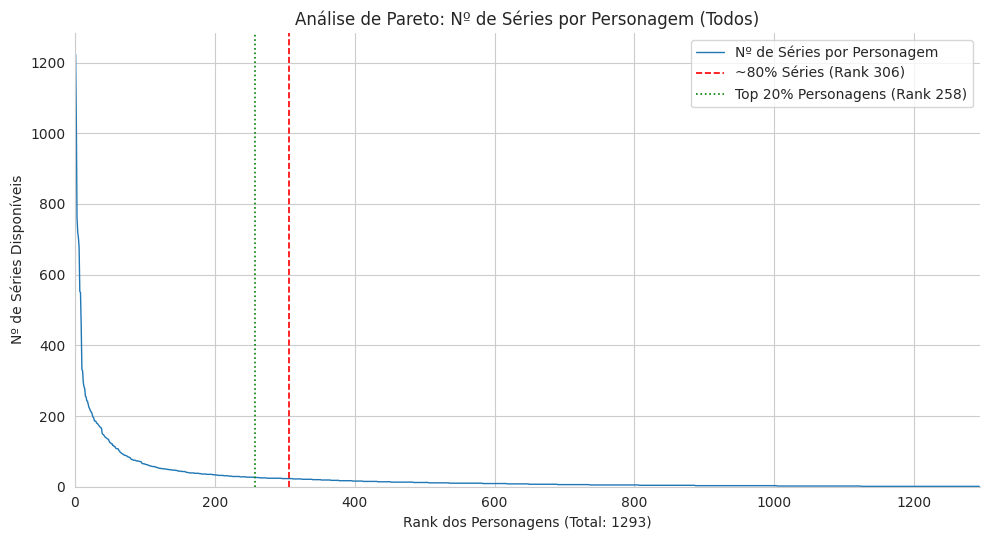

In [17]:
def principio_pareto_series_todos_personagens_conciso(): # Nome da função ligeiramente alterado
    """Busca dados de todos os personagens para a análise de Pareto."""
    with sqlite3.connect(DB_NAME) as conn:
        df = pd.read_sql_query('''
            WITH all_characters_data AS (
                SELECT name, series_available
                FROM characters
                WHERE series_available > 0 -- Apenas personagens com alguma série
            ),
            sum_total AS (
                SELECT SUM(series_available) AS total_series
                FROM all_characters_data
            )
            SELECT
              ROW_NUMBER() OVER (ORDER BY acd.series_available DESC, acd.name ASC) AS rank,
              acd.name,
              acd.series_available,
              ROUND(
                SUM(acd.series_available) OVER (
                  ORDER BY acd.series_available DESC, acd.name ASC
                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                ) * 100.0 / st.total_series, 2
              ) AS pct_acumulada
            FROM all_characters_data acd, sum_total st -- CROSS JOIN implícito
            ORDER BY rank;
        ''', conn) # Query simplificada para retornar apenas o essencial para o gráfico
    return df

# Carrega o DataFrame
# Se df_pareto_todos estiver vazio aqui, o código de plotagem provavelmente falhará.
df_pareto_todos = principio_pareto_series_todos_personagens_conciso()

# --- Gráfico de Pareto o mais resumido e simples possível ---
# Assume-se que df_pareto_todos não está vazio e os pontos de Pareto existem.
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5.5)) # Tamanho de figura mais compacto

# Curva principal (número de séries disponíveis vs rank)
ax.plot(df_pareto_todos['rank'],
        df_pareto_todos['series_available'],
        linestyle='-', linewidth=1, # Estilo mais simples
        label='Nº de Séries por Personagem')

# Ponto de 80% acumulado (sem try-except, pode causar erro se não encontrado)
pareto_point_80 = df_pareto_todos[df_pareto_todos['pct_acumulada'] >= 80].iloc[0]
rank_pareto_80 = pareto_point_80['rank']
ax.axvline(rank_pareto_80, color='red', linestyle='--', linewidth=1.2,
           label=f"~80% Séries (Rank {int(rank_pareto_80)})")

# Linha para os 20% dos personagens
num_total_personagens = len(df_pareto_todos)
if num_total_personagens > 0: # Uma verificação mínima para evitar erro com num_total_personagens = 0
    rank_20_percent = max(1, int(num_total_personagens * 0.20)) # max(1, ...) para evitar rank 0
    ax.axvline(rank_20_percent, color='green', linestyle=':', linewidth=1.2,
               label=f"Top 20% Personagens (Rank {rank_20_percent})")

# Ajustes finais essenciais
ax.set_xlabel(f'Rank dos Personagens (Total: {num_total_personagens})')
ax.set_ylabel('Nº de Séries Disponíveis')
ax.set_title('Análise de Pareto: Nº de Séries por Personagem (Todos)')
ax.legend(loc='upper right')
ax.set_ylim(bottom=0) # Garante que o eixo Y comece em 0
ax.set_xlim(left=0, right=num_total_personagens + 1 if num_total_personagens > 0 else 10)


sns.despine()
plt.tight_layout()
plt.show()


--- Amostra dos Dados da Análise de Pareto (Top 10) ---
 rank                      name  series_available  pct_acumulada
    1 Spider-Man (Peter Parker)              1223           8.31
    2                     X-Men              1043          15.40
    3                 Wolverine               761          20.57
    4           Captain America               721          25.47
    5                  Avengers               705          30.26
    6                  Iron Man               678          34.86
    7                      Thor               553          38.62
    8                      Hulk               549          42.35
    9            Fantastic Four               456          45.45
   10                 Daredevil               332          47.70


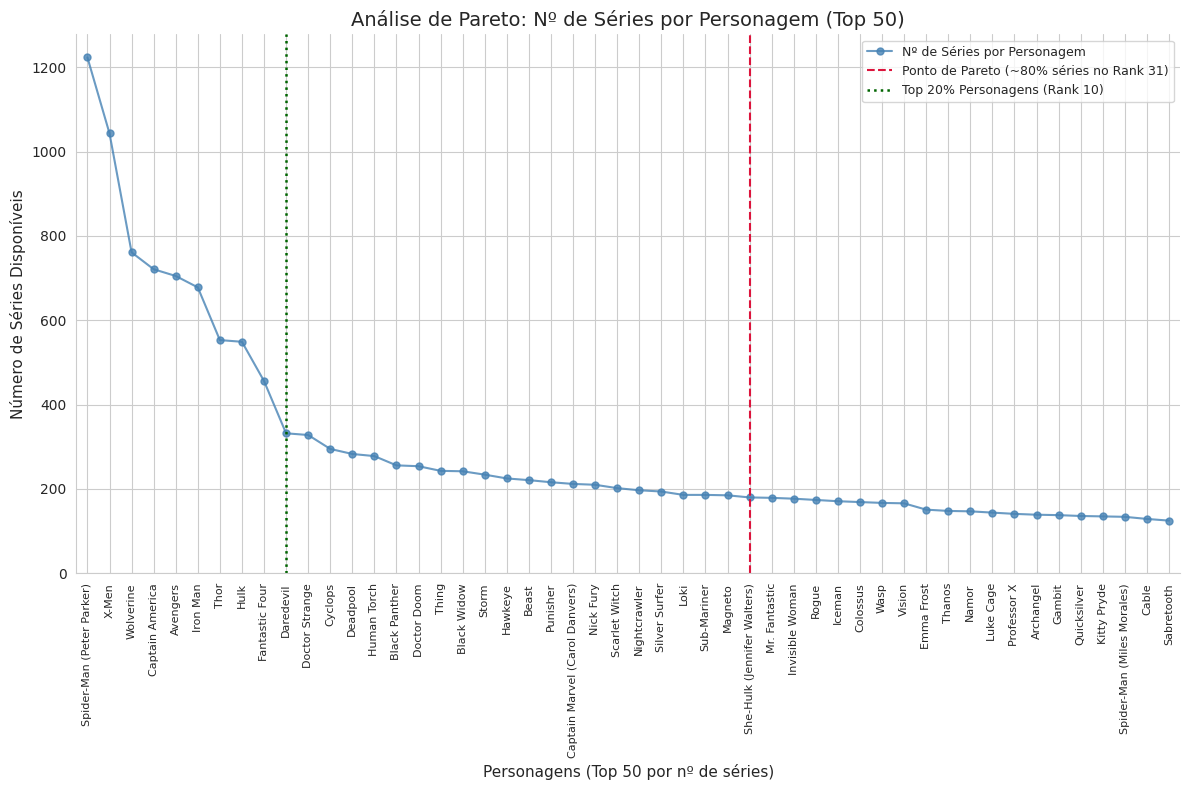

In [18]:
def principio_pareto_series():
    conn = sqlite3.connect(DB_NAME)
    df_principio_pareto = pd.read_sql('''
    WITH
      top50 AS (
        SELECT
          id,
          name,
          series_available
        FROM characters
        ORDER BY series_available DESC
        LIMIT 50
      ),
      sum50 AS (
        SELECT SUM(series_available) AS total_series
        FROM top50
      )
    SELECT
      ROW_NUMBER() OVER (ORDER BY t.series_available DESC) AS rank,
      t.id,
      t.name,
      t.series_available,
      s.total_series AS total_series_top50,
      ROUND(
        t.series_available * 100.0 / s.total_series
      , 2) AS pct_individual,
      ROUND(
        SUM(t.series_available) OVER (
          ORDER BY t.series_available DESC
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) * 100.0 / s.total_series
      , 2) AS pct_acumulada
    FROM top50 AS t
    CROSS JOIN sum50 AS s
    ORDER BY rank;
    ''', conn)
    conn.close()

    print("\n--- Amostra dos Dados da Análise de Pareto (Top 10) ---")
    print(df_principio_pareto[['rank', 'name', 'series_available', 'pct_acumulada']].head(10).to_string(index=False))
    return df_principio_pareto

# Carrega o DataFrame
# Se df_principio_pareto estiver vazio aqui, o código subsequente provavelmente falhará.
df_principio_pareto = principio_pareto_series()

# --- Gráfico de Pareto
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

line_color = 'steelblue'
ax.plot(df_principio_pareto['rank'].values,
        df_principio_pareto['series_available'],
        marker='o', markersize=5, linestyle='-', linewidth=1.5,
        color=line_color, alpha=0.8, label='Nº de Séries por Personagem')

# Ponto de 80% acumulado
pareto_highlight_color_80 = 'crimson'
pareto_point_80 = df_principio_pareto[df_principio_pareto['pct_acumulada'] >= 80].iloc[0]
rank_pareto_80 = pareto_point_80['rank']

ax.axvline(rank_pareto_80, color=pareto_highlight_color_80, linestyle='--', linewidth=1.5,
           label=f"Ponto de Pareto (~80% séries no Rank {int(rank_pareto_80)})")

# Linha para os 20% dos personagens (Top 10 de 50)
rank_20_percent_personagens = 10
color_20_percent_line = 'darkgreen'
ax.axvline(rank_20_percent_personagens,
           color=color_20_percent_line,
           linestyle=':',
           linewidth=1.8,
           label=f"Top 20% Personagens (Rank {rank_20_percent_personagens})")

# Ajustes dos eixos e títulos
ax.set_xlabel('Personagens (Top 50 por nº de séries)', fontsize=11)
ax.set_ylabel('Número de Séries Disponíveis', fontsize=11)
ax.set_title('Análise de Pareto: Nº de Séries por Personagem (Top 50)', fontsize=14)

ax.set_xticks(df_principio_pareto['rank'].values)
ax.set_xticklabels(df_principio_pareto['name'], rotation=90, ha='center', fontsize=8)

ax.legend(loc='upper right', fontsize=9)
ax.tick_params(axis='y', which='major', labelsize=10)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=df_principio_pareto['rank'].max() + 0.5)

sns.despine(fig=fig, ax=ax)
plt.tight_layout()
plt.show()

##5. gráfico:personagens mais presentes em séries em andamento (com preço médio dos quadrinhos)


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


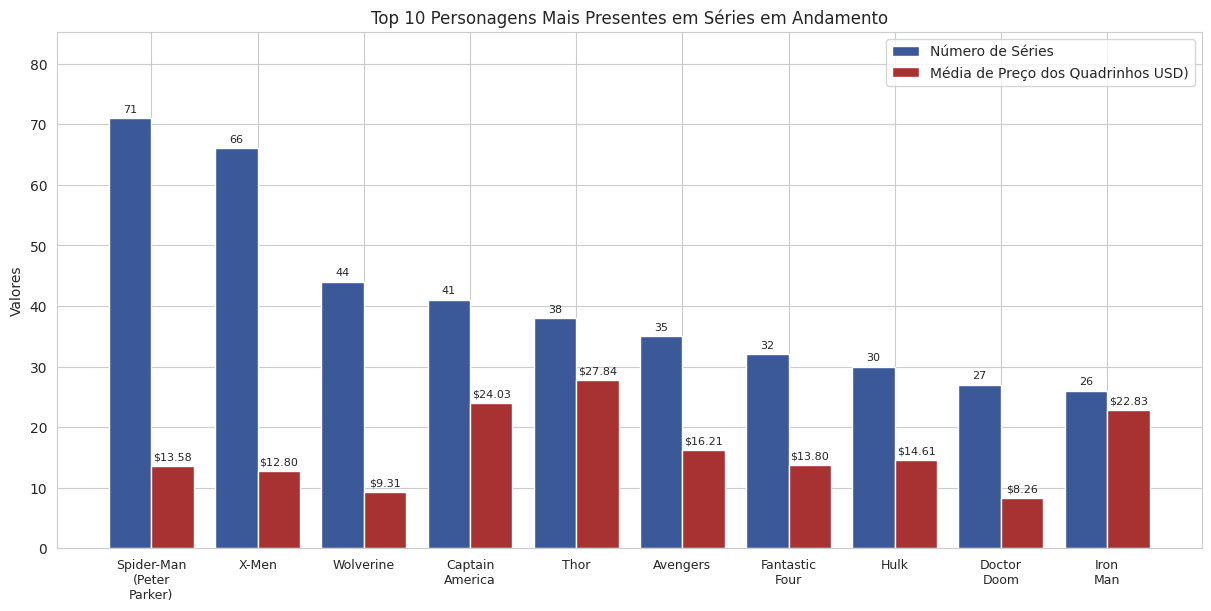

In [19]:
# Função para obter os dados
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''
        WITH series_avg AS (
            SELECT s.id, s.end_year, AVG(c.price) AS media_preco
            FROM comics c
            JOIN series s ON c.id_series = s.id
            WHERE c.price != 0.00
            GROUP BY s.id, s.end_year
        )
        SELECT c.name AS nome_personagem,
               COUNT(s.id) AS num_series,
               ROUND(AVG(s.media_preco), 2) AS media_preco
        FROM characters c
        JOIN characters_series cs ON c.id = cs.id_character
        JOIN series_avg s ON cs.id_serie = s.id
        WHERE s.end_year > 2025
        GROUP BY c.name
        ORDER BY num_series DESC
        LIMIT 10
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

# Obter os dados
df_personagens_mais_em_series = show_table_sample()

# Quebra de linha entre palavras
df_personagens_mais_em_series['nome_personagem'] = df_personagens_mais_em_series['nome_personagem'].apply(
    lambda x: x.replace(' ', '\n')
)

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço dos Quadrinhos USD)']

x = np.arange(len(characters))  # posições
width = 0.4
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

colors = ['#3b5998', '#a83232']  # azul e vermelho

for idx, (attr, label) in enumerate(zip(attributes, labels)):
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        df_personagens_mais_em_series[attr],
        width,
        label=label,
        color=colors[idx]
    )

    # Formatar os rótulos de preço com símbolo $
    if attr == 'media_preco':
        ax.bar_label(rects, labels=[f"${v:.2f}" for v in df_personagens_mais_em_series[attr]], padding=3, fontsize=8)
    else:
        ax.bar_label(rects, padding=3, fontsize=8)

    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens Mais Presentes em Séries em Andamento')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(characters, fontsize=9)  # Quebra de linha já aplicada

ax.legend(loc='upper right')
ax.set_ylim(0, max(
    df_personagens_mais_em_series['num_series'].max(),
    df_personagens_mais_em_series['media_preco'].max()
) * 1.2)

plt.show()


5.1 gráfico: personagens com maior preço médio de quadrinhos de séries em andamento (com número de series > 5)


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


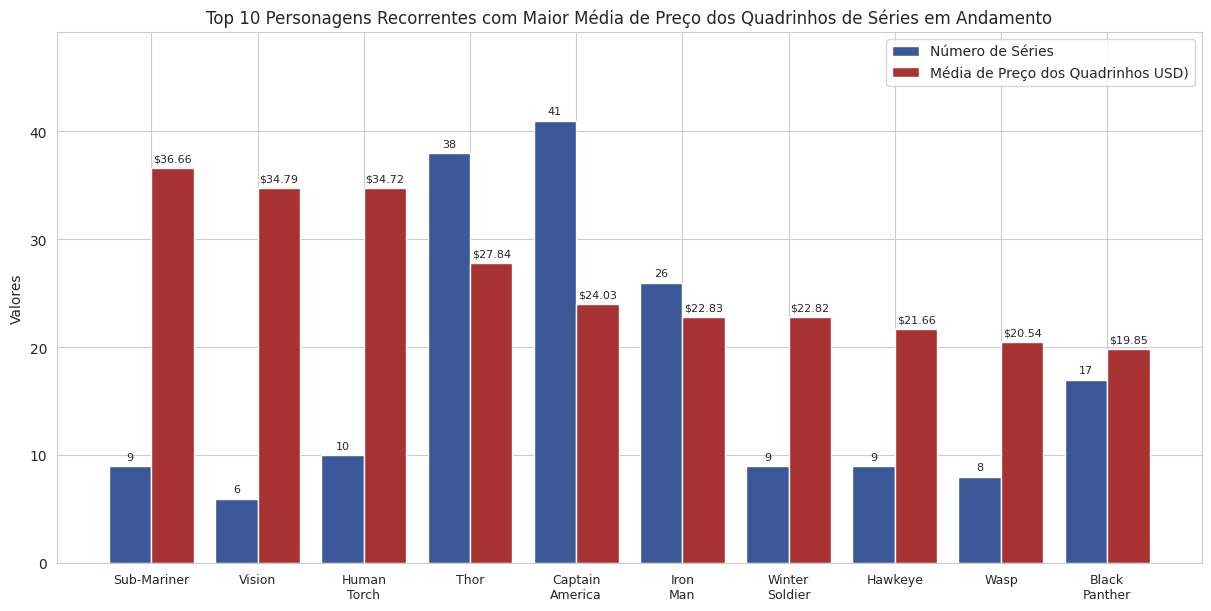

In [20]:
# Função para obter os dados
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''
        WITH series_avg AS (
            SELECT s.id, s.end_year, AVG(c.price) AS media_preco
            FROM comics c
            JOIN series s ON c.id_series = s.id
            WHERE c.price != 0.00
            GROUP BY s.id, s.end_year
        )
        SELECT c.name AS nome_personagem,
               COUNT(s.id) AS num_series,
               ROUND(AVG(s.media_preco), 2) AS media_preco
        FROM characters c
        JOIN characters_series cs ON c.id = cs.id_character
        JOIN series_avg s ON cs.id_serie = s.id
        WHERE s.end_year > 2025
        GROUP BY c.name
        HAVING num_series > 5
        ORDER BY media_preco DESC
        LIMIT 10
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

# Obter os dados
df_personagens_mais_em_series = show_table_sample()

# Quebra de linha entre palavras
df_personagens_mais_em_series['nome_personagem'] = df_personagens_mais_em_series['nome_personagem'].apply(
    lambda x: x.replace(' ', '\n')
)

# Preparando o gráfico
characters = df_personagens_mais_em_series['nome_personagem'].tolist()
attributes = ['num_series', 'media_preco']
labels = ['Número de Séries', 'Média de Preço dos Quadrinhos USD)']

x = np.arange(len(characters))  # posições
width = 0.4
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

colors = ['#3b5998', '#a83232']  # azul e vermelho

for idx, (attr, label) in enumerate(zip(attributes, labels)):
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        df_personagens_mais_em_series[attr],
        width,
        label=label,
        color=colors[idx]
    )

    # Formatar os rótulos de preço com símbolo $
    if attr == 'media_preco':
        ax.bar_label(rects, labels=[f"${v:.2f}" for v in df_personagens_mais_em_series[attr]], padding=3, fontsize=8)
    else:
        ax.bar_label(rects, padding=3, fontsize=8)

    multiplier += 1

# Ajustes finais
ax.set_ylabel('Valores')
ax.set_title('Top 10 Personagens Recorrentes com Maior Média de Preço dos Quadrinhos de Séries em Andamento')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(characters, fontsize=9)  # Quebra de linha já aplicada

ax.legend(loc='upper right')
ax.set_ylim(0, max(
    df_personagens_mais_em_series['num_series'].max(),
    df_personagens_mais_em_series['media_preco'].max()
) * 1.2)

plt.show()


## 6. gráfico formatos de comics e média de preço (com nº de series)


Dados de Quadrinhos por Formato, Quantidade e Média de Preço:
                format  num_comics  media_preço
                 Comic       37179         3.61
       Trade Paperback        6664        23.25
             Hardcover        1694        54.64
                Digest         176         8.69
         Digital Comic         148         2.98
        Infinite Comic          56         2.44
              Magazine          43         6.85
         Graphic Novel          23        16.47
             Newspaper          14         0.25
                Poster          11        13.90
               Catalog           9         1.25
        Hardcover Book           5        28.99
Digital Vertical Comic           5         5.19
            Sketchbook           1         2.99


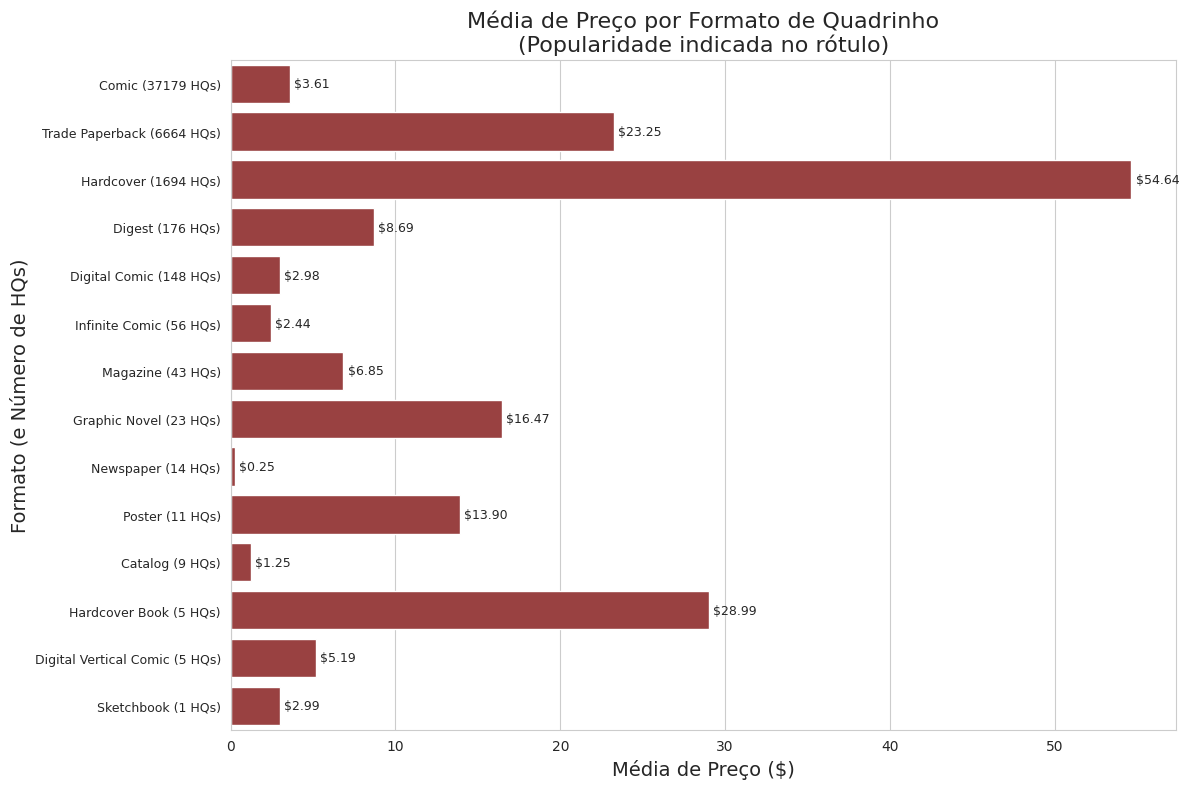

In [21]:
# Sua função para buscar os dados
def get_format_data(): # Renomeado para clareza
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT format,
                               COUNT(id) AS num_comics,
                               ROUND(AVG(price),2) AS media_preço
                        FROM comics
                        WHERE price != 0 AND format != ''
                        GROUP BY format
                        ORDER BY num_comics DESC -- Ordenado pelo número de HQs (mais populares primeiro)
    ''', conn)
    conn.close()

    # A impressão da tabela original é mantida aqui para referência dos dados brutos
    print("\nDados de Quadrinhos por Formato, Quantidade e Média de Preço:")
    print(df.to_string(index=False))
    return df

# Carregar os dados
df_format_analysis = get_format_data()

# --- Gráfico de Barras: Média de Preço por Formato (com Nº de HQs no Rótulo) ---
if not df_format_analysis.empty:
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8)) # Ajustar tamanho para caber os rótulos

    # 1. Criar os rótulos combinados para o eixo Y

    df_format_analysis['format_com_contagem'] = df_format_analysis['format'] + \
                                               " (" + df_format_analysis['num_comics'].astype(str) + " HQs)"

    # 2. Plotar o gráfico de barras horizontais
    # O DataFrame já está ordenado por num_comics DESC, então os formatos mais populares aparecerão primeiro (de cima para baixo)
    # Se quiser ordenar pela média de preço, descomente a linha abaixo:
    # df_format_analysis = df_format_analysis.sort_values('media_preço', ascending=False)

    cor_barras = '#a83232' # vermelho

    barplot = sns.barplot(
        x='media_preço',
        y='format_com_contagem', # Usar a nova coluna com rótulos combinados
        data=df_format_analysis,
        color=cor_barras,
        orient='h' # Garante barras horizontais
    )

    plt.title('Média de Preço por Formato de Quadrinho\n(Popularidade indicada no rótulo)', fontsize=16)
    plt.xlabel('Média de Preço ($)', fontsize=14)
    plt.ylabel('Formato (e Número de HQs)', fontsize=14)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9) # Ajustar tamanho da fonte dos formatos se necessário

    # Adicionar rótulos de dados (valores da média de preço) nas barras
    for container in barplot.containers:
        barplot.bar_label(container, label_type='edge', fontsize=9, padding=3, fmt='$%.2f') # Formato de moeda

    plt.tight_layout()
    plt.show()
else:
    print("\nNão foram encontrados dados de formato para gerar o gráfico.")



Dados de Quadrinhos por Formato, Quantidade e Média de Preço:
                format  num_comics  media_preço
                 Comic       18306         4.47
       Trade Paperback        3272        27.90
             Hardcover         476        94.16
        Infinite Comic          22         2.13
         Digital Comic          21         4.61
                Digest          11         9.99
Digital Vertical Comic           5         5.19


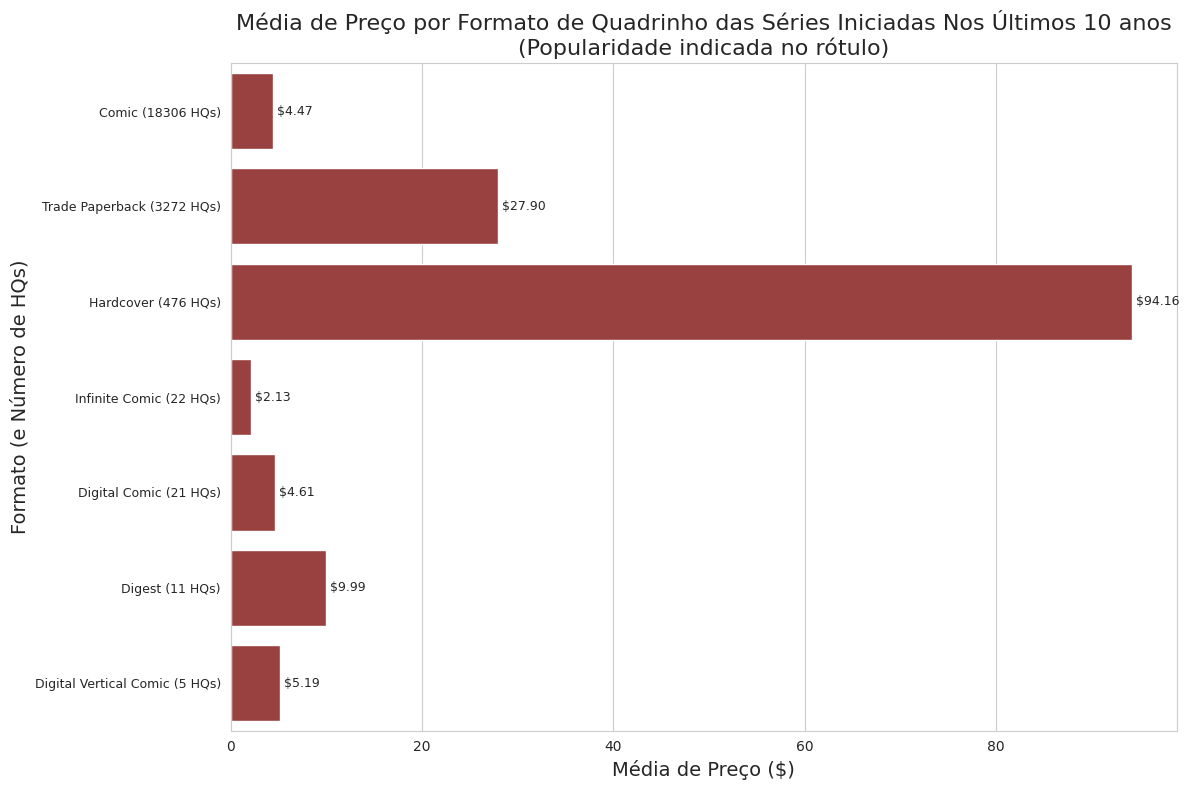

In [22]:
# Sua função para buscar os dados
def get_format_data(): # Renomeado para clareza
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''SELECT c.format, COUNT(c.id) AS num_comics, ROUND(AVG(c.price),2) AS media_preço
                        FROM comics c JOIN series s
                        ON c.id_series = s.id
                        WHERE c.price != 0 AND c.format != '' AND s.start_year > 2015
                        GROUP BY c.format
                        ORDER BY num_comics DESC
    ''', conn)
    conn.close()

    # A impressão da tabela original é mantida aqui para referência dos dados brutos
    print("\nDados de Quadrinhos por Formato, Quantidade e Média de Preço:")
    print(df.to_string(index=False))
    return df

# Carregar os dados
df_format_analysis = get_format_data()

# --- Gráfico de Barras: Média de Preço por Formato (com Nº de HQs no Rótulo) ---
if not df_format_analysis.empty:
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8)) # Ajustar tamanho para caber os rótulos

    # 1. Criar os rótulos combinados para o eixo Y

    df_format_analysis['format_com_contagem'] = df_format_analysis['format'] + \
                                               " (" + df_format_analysis['num_comics'].astype(str) + " HQs)"

    # 2. Plotar o gráfico de barras horizontais
    # O DataFrame já está ordenado por num_comics DESC, então os formatos mais populares aparecerão primeiro (de cima para baixo)
    # Se quiser ordenar pela média de preço, descomente a linha abaixo:
    # df_format_analysis = df_format_analysis.sort_values('media_preço', ascending=False)

    cor_barras = '#a83232' # vermelho

    barplot = sns.barplot(
        x='media_preço',
        y='format_com_contagem', # Usar a nova coluna com rótulos combinados
        data=df_format_analysis,
        color=cor_barras,
        orient='h' # Garante barras horizontais
    )

    plt.title('Média de Preço por Formato de Quadrinho das Séries Iniciadas Nos Últimos 10 anos\n(Popularidade indicada no rótulo)', fontsize=16)
    plt.xlabel('Média de Preço ($)', fontsize=14)
    plt.ylabel('Formato (e Número de HQs)', fontsize=14)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9) # Ajustar tamanho da fonte dos formatos se necessário

    # Adicionar rótulos de dados (valores da média de preço) nas barras
    for container in barplot.containers:
        barplot.bar_label(container, label_type='edge', fontsize=9, padding=3, fmt='$%.2f') # Formato de moeda

    plt.tight_layout()
    plt.show()
else:
    print("\nNão foram encontrados dados de formato para gerar o gráfico.")


##7 gráfico: eventos com mais séries (com nº de personagens)


Amostra dos dados:
Dimensões: 10 linhas x 3 colunas


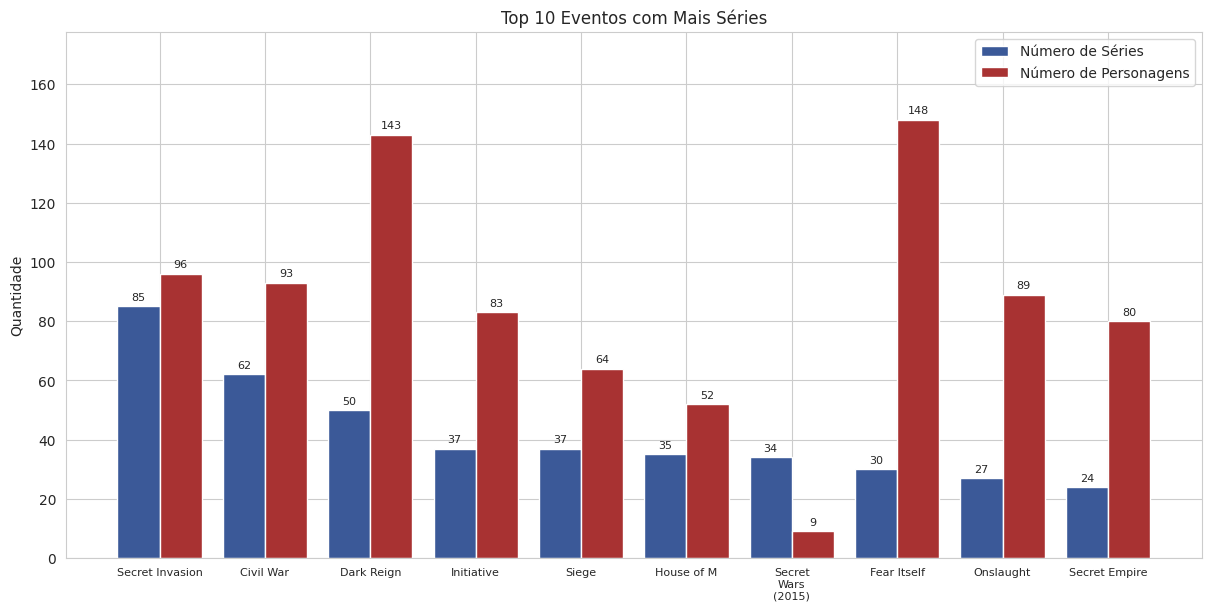

In [23]:
# Função para obter os dados
def show_table_sample():
    conn = sqlite3.connect(DB_NAME)
    df = pd.read_sql('''
        WITH events_count_series AS (
            SELECT e.id, COUNT(es.id_serie) AS num_series
            FROM events e
            JOIN events_series es ON e.id = es.id_event
            GROUP BY e.id
        ),
        events_count_characters AS (
            SELECT e.id, COUNT(ce.id_character) AS num_characters
            FROM events e
            JOIN characters_events ce ON e.id = ce.id_event
            GROUP BY e.id
        )
        SELECT e.title AS evento, ecs.num_series, ecc.num_characters
        FROM events e
        JOIN events_count_series ecs ON e.id = ecs.id
        JOIN events_count_characters ecc ON e.id = ecc.id
        ORDER BY ecs.num_series DESC
        LIMIT 10
    ''', conn)
    conn.close()

    print("\nAmostra dos dados:")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    return df

# Obter os dados
df_eventos = show_table_sample()

# Quebra de linha para eventos com nome muito longo
df_eventos['evento'] = df_eventos['evento'].apply(lambda x: x.replace(' ', '\n') if len(x) > 15 else x)

# Preparando o gráfico
eventos = df_eventos['evento'].tolist()
attributes = ['num_series', 'num_characters']
labels = ['Número de Séries', 'Número de Personagens']

x = np.arange(len(eventos))  # posições
width = 0.4
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')

colors = ['#3b5998', '#a83232']  # azul e vermelho

for idx, (attr, label) in enumerate(zip(attributes, labels)):
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        df_eventos[attr],
        width,
        label=label,
        color=colors[idx]
    )
    ax.bar_label(rects, padding=3, fontsize=8)
    multiplier += 1

# Ajustes finais
ax.set_ylabel('Quantidade')
ax.set_title('Top 10 Eventos com Mais Séries')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(eventos, fontsize=8)

ax.legend(loc='upper right')

# Ajustar limite superior
max_val = max(df_eventos['num_series'].max(), df_eventos['num_characters'].max())
ax.set_ylim(0, max_val * 1.2)

plt.show()



Dados dos Top Eventos (incluindo anos min/max das séries associadas):
            evento  num_series  num_characters  first_series_start_year  last_finished_series_end_year
   Secret Invasion          85              96                     2004                           2013
         Civil War          62              93                     1998                           2013
        Dark Reign          50             143                     1981                           2013
        Initiative          37              83                     1998                           2012
             Siege          37              64                     2004                           2012
        House of M          35              52                     1938                           2011
Secret Wars (2015)          34               9                     2014                           2016
       Fear Itself          30             148                     1981                           2013
  

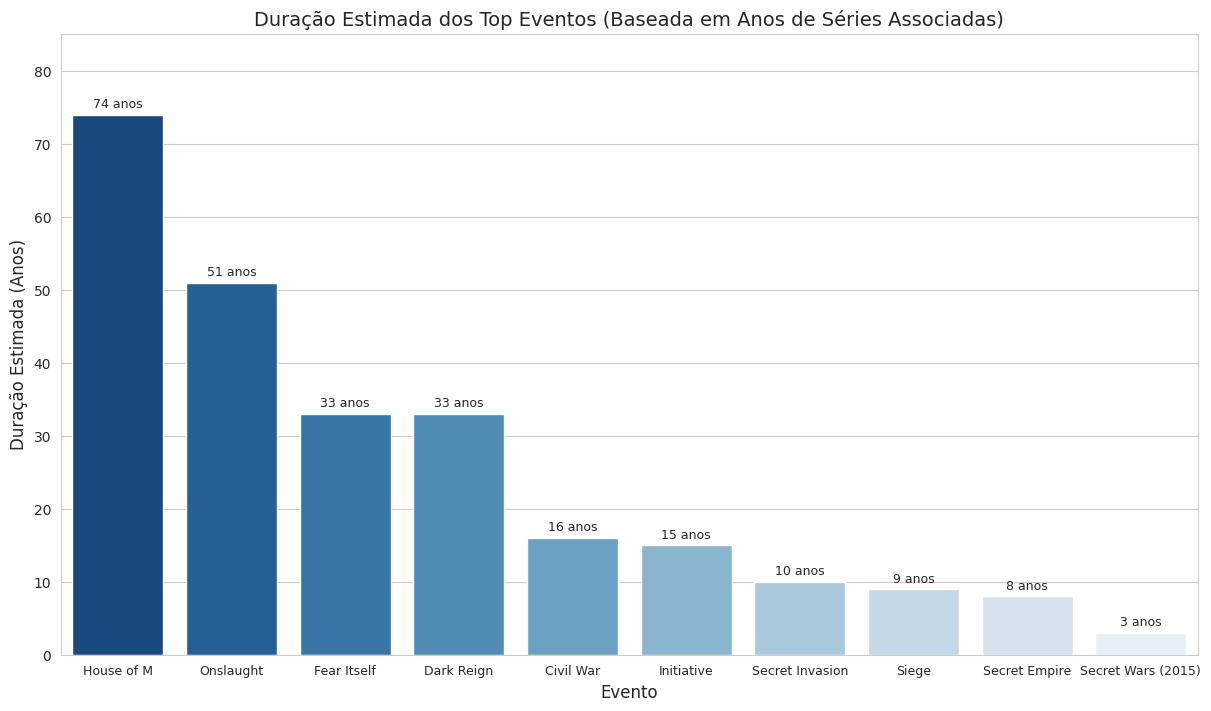

In [24]:
# Função para obter os dados
def get_top_events_details_with_series_years(limit=10):
    conn = sqlite3.connect(DB_NAME)
    query = f'''
        WITH
        events_count_series AS (
            SELECT e.id, COUNT(DISTINCT es.id_serie) AS num_series
            FROM events e
            LEFT JOIN events_series es ON e.id = es.id_event
            GROUP BY e.id
        ),
        events_count_characters AS (
            SELECT e.id, COUNT(DISTINCT ce.id_character) AS num_characters
            FROM events e
            LEFT JOIN characters_events ce ON e.id = ce.id_event
            GROUP BY e.id
        ),
        event_min_series_start_year AS (
            SELECT
                es.id_event,
                MIN(s.start_year) AS first_series_start_year
            FROM events_series es
            JOIN series s ON es.id_serie = s.id
            WHERE s.start_year IS NOT NULL
            GROUP BY es.id_event
        ),
        event_max_finished_series_end_year AS (
            SELECT
                es.id_event,
                MAX(s.end_year) AS last_finished_series_end_year
            FROM events_series es
            JOIN series s ON es.id_serie = s.id
            WHERE s.end_year IS NOT NULL
              AND s.end_year < 2025
              AND s.start_year IS NOT NULL
              AND s.end_year >= s.start_year
            GROUP BY es.id_event
        )
        SELECT
            e.title AS evento,
            IFNULL(ecs.num_series, 0) AS num_series,
            IFNULL(ecc.num_characters, 0) AS num_characters,
            ems.first_series_start_year,
            emf.last_finished_series_end_year
        FROM events e
        LEFT JOIN events_count_series ecs ON e.id = ecs.id
        LEFT JOIN events_count_characters ecc ON e.id = ecc.id
        LEFT JOIN event_min_series_start_year ems ON e.id = ems.id_event
        LEFT JOIN event_max_finished_series_end_year emf ON e.id = emf.id_event
        WHERE e.title IS NOT NULL AND e.title != ''
        ORDER BY num_series DESC, num_characters DESC
        LIMIT {limit};
    '''
    df = pd.read_sql_query(query, conn)
    conn.close()

    print("\nDados dos Top Eventos (incluindo anos min/max das séries associadas):")
    print(df.to_string(index=False))
    return df

# Obter os dados
df_eventos_com_anos = get_top_events_details_with_series_years()

# --- Gráfico 2: Duração Estimada dos Top 10 Eventos (em ANOS) ---
if not df_eventos_com_anos.empty:
    df_duracao = df_eventos_com_anos.copy()

    df_duracao['start_date'] = pd.to_datetime(df_duracao['first_series_start_year'], format='%Y', errors='coerce') # Formatando como ano
    df_duracao['end_date'] = pd.to_datetime(df_duracao['last_finished_series_end_year'], format='%Y', errors='coerce')

    # Calcular duração em anos diretamente se as colunas já são anos
    # Ou calcular a partir das datas completas se elas fossem datas completas.
    # Como first_series_start_year e last_finished_series_end_year já são anos:
    mask_valid_duration = (df_duracao['first_series_start_year'].notna() &
                           df_duracao['last_finished_series_end_year'].notna() &
                           (df_duracao['last_finished_series_end_year'] >= df_duracao['first_series_start_year']))

    df_duracao.loc[mask_valid_duration, 'duracao_anos'] = \
        (df_duracao.loc[mask_valid_duration, 'last_finished_series_end_year'] -
         df_duracao.loc[mask_valid_duration, 'first_series_start_year']) + 1

    df_plot_duracao = df_duracao[df_duracao['duracao_anos'].notna() & (df_duracao['duracao_anos'] > 0)].copy()
    df_plot_duracao['evento_display'] = df_plot_duracao['evento'].apply(lambda x: x.replace(' ', '\n') if len(x) > 20 else x)

    if not df_plot_duracao.empty:
        df_plot_duracao = df_plot_duracao.sort_values('duracao_anos', ascending=False)

        fig2, ax2 = plt.subplots(figsize=(12, 7), layout='constrained')
        sns.set_style("whitegrid")

        cor_duracao = '#2E8B57'

        barplot_duracao = sns.barplot(
            x='evento_display',
            y='duracao_anos',
            data=df_plot_duracao,
            palette="Blues_r", # Exemplo de paleta (invertida para o maior ter cor mais escura)
            hue='evento_display', # Para aplicar a paleta corretamente barra a barra
            dodge=False,          # Evitar que as barras se desloquem
            legend=False          # Não precisamos de legenda para o hue aqui
        )

        ax2.set_title('Duração Estimada dos Top Eventos (Baseada em Anos de Séries Associadas)', fontsize=14)
        ax2.set_xlabel('Evento', fontsize=12)
        ax2.set_ylabel('Duração Estimada (Anos)', fontsize=12)
        # CORREÇÃO: Removido ha='center' de tick_params
        ax2.tick_params(axis='x', rotation=0, labelsize=9)
        ax2.tick_params(axis='y', labelsize=10)

        for container in barplot_duracao.containers:
            ax2.bar_label(container, label_type='edge', fontsize=9, padding=3, fmt='%.0f anos')

        max_val2 = df_plot_duracao['duracao_anos'].max() if not df_plot_duracao.empty else 0
        ax2.set_ylim(0, max_val2 * 1.15 if max_val2 > 0 else 1)
        plt.show()
    else:
        print("\nNão foi possível calcular a duração em anos para os eventos listados ou nenhum tem duração positiva.")
else:
    print("Não há dados de eventos para o gráfico de duração.")